In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"arnavgoel26","key":"3ef3ea797bd04e15077e5c8ee174f4a3"}'}

In [2]:
import json
import os

# Save the uploaded file
with open('kaggle (1).json', 'r') as f:
    kaggle_data = json.load(f)

# Set permissions
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_data, f)

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


In [3]:
import os
import shutil

In [4]:
!kaggle datasets download -d nirmalsankalana/sugarcane-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/sugarcane-leaf-disease-dataset
License(s): CC0-1.0


In [5]:
!unzip sugarcane-leaf-disease-dataset.zip -d sugarcane_dataset


Archive:  sugarcane-leaf-disease-dataset.zip
  inflating: sugarcane_dataset/Healthy/healthy (1).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (10).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (100).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (101).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (102).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (103).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (104).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (105).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (106).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (107).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (108).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (109).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (11).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (110).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (111).jpeg  
  inflating: sugarcane_dataset/Healthy/healthy (112).jpeg  

In [6]:
directory_path = r'/content/sugarcane_dataset'


In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle="True",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 2521 files belonging to 5 classes.


In [10]:
class_names=dataset.class_names
class_names

['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

Mosaic: 462
RedRot: 518
Healthy: 522
Rust: 514
Yellow: 505


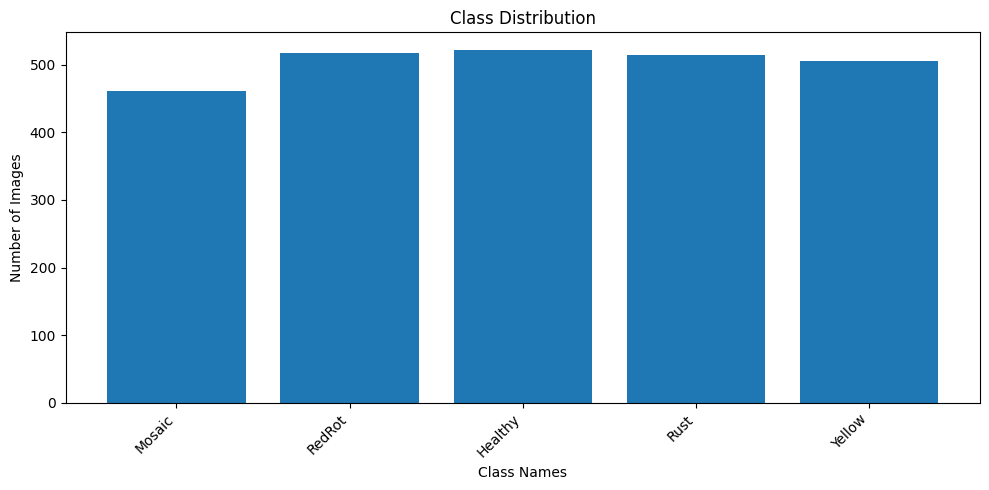

In [11]:
# prompt: get count of each class

import matplotlib.pyplot as plt

# Assuming 'dataset' is already defined from the previous code
class_counts = {}
for images, labels in dataset:
    for label in labels.numpy():
        class_name = class_names[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

# Print the class counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Optional: Visualize the class distribution using a bar chart
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [12]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size).cache().shuffle(buffer_size=1000)
val_dataset = dataset.skip(train_size).cache()

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Efficient Net

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model

input_layer = layers.Input(shape=(256, 256, 3), name="input")

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

base_model.trainable = False

x = base_model.output
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.GlobalAveragePooling2D()(x)
output_layer = layers.Dense(5, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 7,005,352 (26.72 MB)

 Trainable params: 2,953,221 (11.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [14]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        verbose=1
    )

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 464ms/step - accuracy: 0.5011 - loss: 6.2054 - val_accuracy: 0.6851 - val_loss: 1.2886
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8301 - loss: 0.6900 - val_accuracy: 0.8000 - val_loss: 0.7884
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8994 - loss: 0.3082 - val_accuracy: 0.9010 - val_loss: 0.3713
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9278 - loss: 0.2146 - val_accuracy: 0.9010 - val_loss: 0.3276
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9601 - loss: 0.1163 - val_accuracy: 0.9188 - val_loss: 0.3097
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9578 - loss: 0.1273 - val_accuracy: 0.9347 - val_loss: 0.2940
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9661 - loss: 0.1069 - val_accuracy: 0.9188 - val_loss: 0.3676
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9667 - loss: 0.1285 - val_accuracy: 0.9228 -

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9268 - loss: 0.3565
Test Loss: 0.3063684403896332
Test Accuracy: 0.9267326593399048
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [17]:
class_names=["Healthy","Mosiac","Red Rot", "Rust","Yellow"]

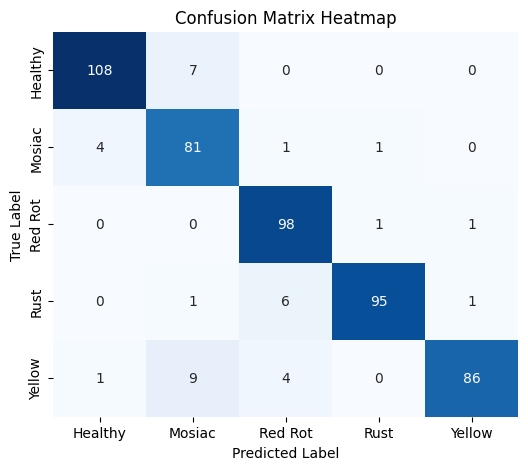

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names,cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [19]:
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       115
           1       0.83      0.93      0.88        87
           2       0.90      0.98      0.94       100
           3       0.98      0.92      0.95       103
           4       0.98      0.86      0.91       100

    accuracy                           0.93       505
   macro avg       0.93      0.93      0.93       505
weighted avg       0.93      0.93      0.93       505

Accuracy: 0.9267326732673268


# VGG 16

In [20]:
from tensorflow.keras.applications import VGG16

input_layer = layers.Input(shape=(256, 256, 3), name="input")
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)
base_model.trainable = False  # Freeze layers

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
output_layer = layers.Dense(5, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
for images, labels in train_dataset.take(1):
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)

# Train the model
try:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        verbose=1
    )
except Exception as e:
    print("Error during training:", e)

Image shape: (32, 256, 256, 3)
Label shape: (32,)
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 441ms/step - accuracy: 0.2576 - loss: 3.1790 - val_accuracy: 0.5525 - val_loss: 1.3236
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.5620 - loss: 1.3271 - val_accuracy: 0.6634 - val_loss: 0.9818
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step - accuracy: 0.6575 - loss: 0.9614 - val_accuracy: 0.7446 - val_loss: 0.8062
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.7153 - loss: 0.7826 - val_accuracy: 0.7624 - val_loss: 0.7152
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.7648 - loss: 0.6506 - val_accuracy: 0.7723 - val_loss: 0.6439
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.7836 - loss: 0.6008 - val_accuracy: 0.8020 - val_loss: 0.5981
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - accuracy: 0.8002 - loss: 0.5271 - val_accuracy: 0.8020 - val_loss: 0.5709
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.8622 - loss: 0.3627
Test Loss: 0.40712597966194153
Test Accuracy: 0.8455445766448975
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


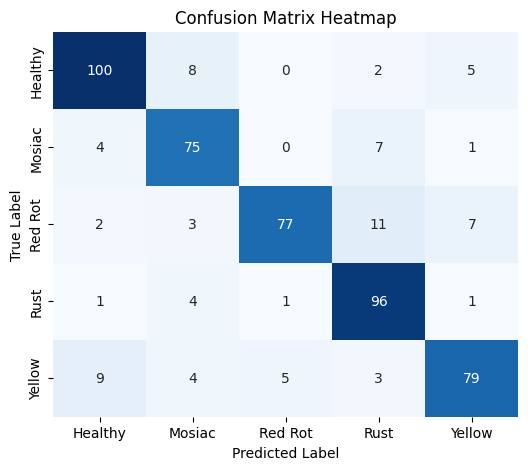

In [24]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names,cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [25]:
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       115
           1       0.80      0.86      0.83        87
           2       0.93      0.77      0.84       100
           3       0.81      0.93      0.86       103
           4       0.85      0.79      0.82       100

    accuracy                           0.85       505
   macro avg       0.85      0.84      0.84       505
weighted avg       0.85      0.85      0.85       505

Accuracy: 0.8455445544554455


# ResNet

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load Pretrained ResNet50 (Exclude top layers, use ImageNet weights)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze base model layers (optional, for transfer learning)
base_model.trainable = False  # Set to True if you want to fine-tune

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Summary of the model
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,769,413 (94.49 MB)

 Trainable params: 1,181,701 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [27]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        verbose=1
    )

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 255ms/step - accuracy: 0.5605 - loss: 1.1606 - val_accuracy: 0.8198 - val_loss: 0.5216
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.8337 - loss: 0.4754 - val_accuracy: 0.8495 - val_loss: 0.3831
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.8718 - loss: 0.3346 - val_accuracy: 0.8713 - val_loss: 0.3795
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.9152 - loss: 0.2337 - val_accuracy: 0.8931 - val_loss: 0.2934
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.9516 - loss: 0.1521 - val_accuracy: 0.8891 - val_loss: 0.2842
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9517 - loss: 0.1220 - val_accuracy: 0.9030 - val_loss: 0.2750
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9684 - loss: 0.0916 - val_accuracy: 0.8812 - val_loss: 0.3714
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.9761 - loss: 0.0724 - val_accuracy: 

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9206 - loss: 0.2860
Test Loss: 0.29684847593307495
Test Accuracy: 0.9168316721916199
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


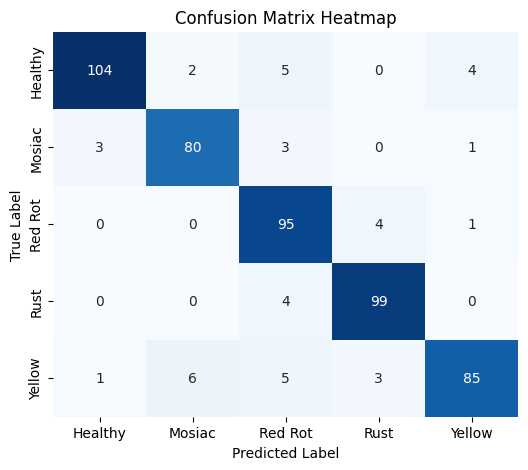

In [30]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names,cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [31]:
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       115
           1       0.91      0.92      0.91        87
           2       0.85      0.95      0.90       100
           3       0.93      0.96      0.95       103
           4       0.93      0.85      0.89       100

    accuracy                           0.92       505
   macro avg       0.92      0.92      0.92       505
weighted avg       0.92      0.92      0.92       505

Accuracy: 0.9168316831683169


# DenseNet

In [32]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2

input_layer = layers.Input(shape=(256, 256, 3), name="input")

base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)
base_model.trainable = False  # Unfreeze later for fine-tuning

# Custom Layers
x = layers.BatchNormalization()(base_model.output)
x = layers.ReLU()(x)
x = layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)  # L2 Regularization
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)  # 40% Dropout for Regularization
output_layer = layers.Dense(5, activation='softmax')(x)  # 4 Classes

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ input[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 9,402,437 (35.87 MB)

 Trainable params: 2,362,885 (9.01 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [33]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=15,
        verbose=1
    )

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 465ms/step - accuracy: 0.4273 - loss: 5.7086 - val_accuracy: 0.6317 - val_loss: 2.3982
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.7123 - loss: 1.6041 - val_accuracy: 0.7703 - val_loss: 1.2696
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.7808 - loss: 1.2011 - val_accuracy: 0.7604 - val_loss: 1.2268
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.8079 - loss: 1.0455 - val_accuracy: 0.8554 - val_loss: 0.9144
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8338 - loss: 0.9340 - val_accuracy: 0.8297 - val_loss: 0.9931
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.8677 - loss: 0.8186 - val_accuracy: 0.8614 - val_loss: 0.9148
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8957 - loss: 0.6775 - val_accuracy: 0.8238 - val_loss: 0.9942
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.9042 - loss: 0.6285 - val_accuracy:

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9170 - loss: 0.6974
Test Loss: 0.7790240049362183
Test Accuracy: 0.8891088962554932
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


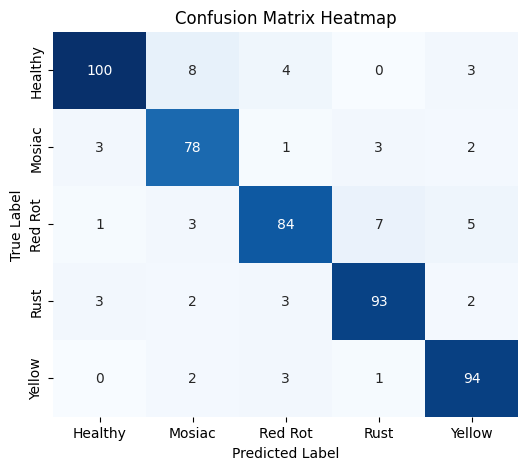

In [36]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names,cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [37]:
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       115
           1       0.84      0.90      0.87        87
           2       0.88      0.84      0.86       100
           3       0.89      0.90      0.90       103
           4       0.89      0.94      0.91       100

    accuracy                           0.89       505
   macro avg       0.89      0.89      0.89       505
weighted avg       0.89      0.89      0.89       505

Accuracy: 0.8891089108910891
